In [4]:
# Mixed precision training.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.7.0


In [3]:
tf.config.list_physical_devices("GPU")

2022-01-23 23:07:19.432199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-23 23:07:19.456146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-23 23:07:19.456565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
all_datasets = list(tfds.list_builders())

In [5]:
all_datasets

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adroit_hammer',
 'd4rl_adroit_pen',
 'd4rl_adroit_relocate',
 'd4rl_mujoco_ant',
 'd4

In [6]:
"food101" in all_datasets

True

In [7]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], 
                                             shuffle_files=True,
                                             with_info=True,
                                             as_supervised=True,
                                            )

2022-01-23 23:07:21.553286: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-23 23:07:21.554081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-23 23:07:21.554730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-23 23:07:21.555524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

(512, 384, 3) <dtype: 'uint8'>
tf.Tensor(74, shape=(), dtype=int64)


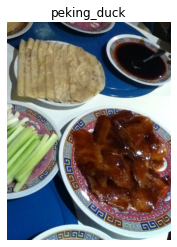

In [10]:
sample = train_data.take(1)
for sample_tensor, sample_label in sample:
    print(sample_tensor.shape, sample_tensor.dtype)
    print(sample_label)
    plt.imshow(sample_tensor)
    plt.title(class_names[sample_label.numpy()])
    plt.axis(False)

In [11]:
def preprocess_image(image, image_label, image_shape=224):
    resized_image = tf.image.resize(image, [image_shape, image_shape])
    preprocessed_image = tf.cast(resized_image, tf.float32)
    return preprocessed_image, image_label


In [12]:
# map a preprocess function tot hte train data
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [17]:
import os

model_name = "101_classes_10_percent"
checkpoint_path = f"model_logs/checkpoints/{model_name}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                               save_weights_only=True,
                                                               monitor="val_acc",
                                                               save_best_only=True)
def create_tensorboard_callback(experiment_name, model_name):
    log_dir = os.path.join("model_logs", str(experiment_name),
                           str(model_name), dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"[create_tensorboard_callback] The log dir for tensorboard is : {log_dir}")
    return tensorboard_callback
tensorboard_callback = create_tensorboard_callback("food_sight", model_name)

[create_tensorboard_callback] The log dir for tensorboard is : model_logs/food_sight/101_classes_10_percent/20220123-231232


In [18]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


2022-01-23 23:18:47.887965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [20]:
tf.random.set_seed(273)

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

layer_2 = base_model(inputs, training=False)
pooling_layer = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(layer_2)
outputs_base = tf.keras.layers.Dense(units=101, name="output_base_layer")(pooling_layer)
outputs = tf.keras.layers.Activation(activation="softmax", dtype=tf.float32, name="softmax_float32")(outputs_base)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)
model.summary()

Model: "101_classes_10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_base_layer (Dense)   (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 12

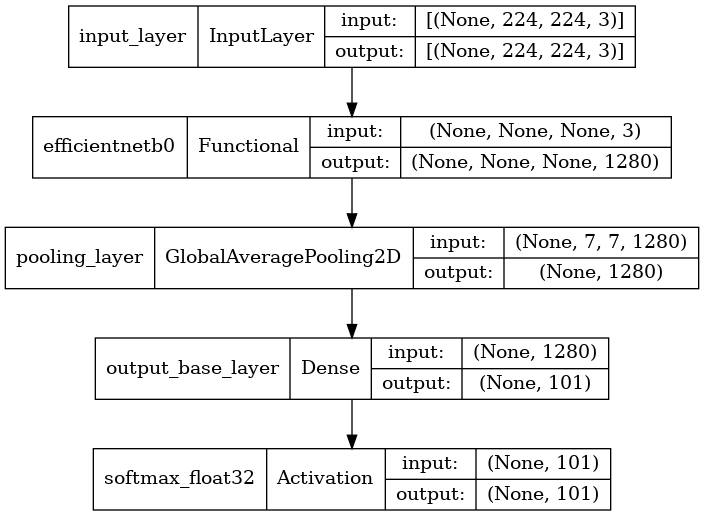

In [23]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
history_101_food_classes = model.fit(train_data,
                                     validation_data=test_data,
                                     epochs=3,
                                     steps_per_epoch=len(train_data),
                                     callbacks=[tensorboard_callback, model_checkpoint_callback],
                                     validation_steps=len(test_data))

/home/arun/learn/tensorflow_certification/venv/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3


2022-01-23 23:37:13.456543: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


2368/2368 [==============================] - 517s 214ms/step - loss: 1.8195 - accuracy: 0.5581 - val_loss: 1.2361 - val_accuracy: 0.6755
Epoch 2/3
2368/2368 [==============================] - 451s 190ms/step - loss: 1.2926 - accuracy: 0.6659 - val_loss: 1.1262 - val_accuracy: 0.7011
Epoch 3/3
2368/2368 [==============================] - 446s 188ms/step - loss: 1.1426 - accuracy: 0.7022 - val_loss: 1.0898 - val_accuracy: 0.7063
